## Машинное обучение 

### Факультет математики НИУ ВШЭ, 2019-20 учебный год

_Илья Щуров, Соня Дымченко, Руслан Хайдуров, Александр Каган, Павел Балтабаев_

[Страница курса](http://wiki.cs.hse.ru/Машинное_обучение_на_матфаке_2020)


## Домашнее задание 4. Линейные модели и градиентный спуск.

В данном задании необходимо реализовать обучение логистической и линейной регрессий с помощью различных вариантов градиентного спуска.

Правила оценивания найдите на странице курса.

## Часть 1: Реализация градиентного спуска.

Реализуйте логистическую регрессию с лог-лоссом, обучаемую с помощью:

**Задание 1 (1 балл)** Градиентного спуска;

**Задание 2 (1.5 балла)** Стохастического градиентного спуска;

**Задание 3 (1.5 балла)** Стохастического градиентного спуска с Momentum.

Подробнее о методах можно прочитать [тут](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture02-linregr.pdf). Напомним, что лог-лосс вычисляется по формуле
$$
    \mathcal{L}(y, X, w) = -\cfrac{1}{n} \sum_{i=1}^{n} [y_i=1]\log \sigma(\langle w, x_i\rangle) + [y_i=0]\log (1 - \sigma(\langle w, x_i\rangle)) + \lambda_2 ||w||_2^2 + \lambda_1 ||w||_1
$$
где $\sigma(x) = 1 / (1 + \exp(-x))$, а $\lambda_1, \lambda_2 > 0$ -- параметры регуляризации. Считайте, что либо $\lambda_1 = 0$, либо $\lambda_2 = 0$. 

Во всех пунктах необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускается использовать только для итераций градиентного спуска в методе fit; также разрешается использовать только стандартные средства языка Python и библиотеку numpy.
* Обучение необходимо приостанавливать, если выполнено хотя бы одно из двух условий:

    * проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
    * достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).
* Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);
* Инициализировать веса можно случайным образом или нулевым вектором. 


Ниже приведён шаблон класса, который должен содержать код реализации каждого из методов.

In [89]:
import numpy as np
from sklearn.base import BaseEstimator


class LogReg(BaseEstimator):
    def __init__(self, lambda_1=0.0, lambda_2=1.0, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3, nu=0.0):
        """
        lambda_1: L1 regularization param
        lambda_2: L2 regularization param
        gd_type: 'full', 'stochastic' or 'momentum'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        alpha: learning rate
        nu: param for 'momentum' method of gd. 
            By default is 0, what means it is same is full method until changed
        """
        if lambda_1 * lambda_2 != 0:
            self.lambda_1 = 0
            self.lambda_2 = 0
            raise Exception('Double regularization')
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.gd_type = gd_type
        self.nu = nu
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = w0
        self.alpha = alpha
        self.loss_history = []

    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        l, d = X.shape
        if self.w is None:
            self.w = np.random.uniform(0, 1, d)
        if self.gd_type == 'full':
            return self.fit_mode_full(X, y)
        elif self.gd_type == 'stochastic':
            return self.fit_mode_stochastic(X, y)
        elif self.gd_type == 'momentum':
            return self.fit_mode_momentum(X, y)
        else:
            raise Exception('Unknown gd_type')

    def fit_mode_full(self, X, y):
        """
        ....
        :param X: np.array of shape (l, d)
        :param y: np.array of shape (l)
        :return: fitted wieght
        """
        l, d = X.shape
        for i in range(self.max_iter):
            last_w = self.w.copy()
            self.loss_history.append(self.calc_loss(X, y))
            self.w -= self.calc_gradient(X, y)
            if np.linalg.norm(last_w - self.w) <= self.tolerance:
                print('finished at step {} out of {}'.format(i, self.max_iter))
                break
        return self.w

    def fit_mode_stochastic(self, X, y):
        """
        ....
        :param X: np.array of shape (l, d)
        :param y: np.array of shape (l)
        :return: fitted wieght
        """
        l, d = X.shape
        for i in range(self.max_iter):
            k = np.random.randint(l)
            X_calc, y_calc = np.array([X[k]]), np.array([y[k]])
            last_w = self.w.copy()
            self.loss_history.append(self.calc_loss(X_calc, y_calc))
            self.w -= self.calc_gradient(X_calc, y_calc)
            if np.linalg.norm(last_w - self.w) <= self.tolerance:
                print('finished at step {} out of {}'.format(i, self.max_iter))
                break
        return self.w

    def fit_mode_momentum(self, X, y):
        """
        ....
        :param X: np.array of shape (l, d)
        :param y: np.array of shape (l)
        :return: fitted wieght
        """
        l, d = X.shape
        self.gradient = 0
        for i in range(self.max_iter):
            last_w = self.w.copy()
            self.loss_history.append(self.calc_loss(X, y))
            self.gradient = self.nu * self.gradient + self.calc_gradient(X, y)
            self.w -= self.gradient
            if np.linalg.norm(last_w - self.w) <= self.tolerance:
                print('finished at step {} out of {}'.format(i, self.max_iter))
                break
        return self.w

    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        return np.array([1 - self.sigma((X @ self.w)), self.sigma(X @ self.w)]).T

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        l, d = X.shape
        reg = self.lambda_1 * np.sign(self.w) + 2 * self.lambda_2 * self.w
        loss = (self.sigma(X @ self.w) - y) @ X
        return self.alpha * (loss / l + reg)

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """
        l, d = X.shape
        reg = self.lambda_1 * np.sum(np.abs(self.w)) + self.lambda_2 * np.sum(np.power(self.w, 2))
        loss = np.sum(np.where(y == 1, np.log(self.sigma(X @ self.w)), np.log(1 - self.sigma(X @ self.w))))
        return - loss / l + reg

    def sigma(self, x):
        """
        :param x: input value or vector 
        :return: sigmoid value or vector
        """
        return 1 / (1 + np.exp(-x))


In [91]:
X = np.array([[-2.2], [-1.4], [-.8], [.2], [.4], [.8], [1.2], [2.2], [2.9], [4.6]])
y = np.array([0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
w = None

full = LogReg(lambda_2=0.1, w0=w, alpha=0.1, max_iter=100000, tolerance=0.00001,
              gd_type='full')
print('Full gd_type')
print('w= ', full.fit(X, y))
print(full.calc_loss(X, y), '\n')

st = LogReg(lambda_2=0.1, w0=w, alpha=0.1, max_iter=100000, tolerance=1e-9,
            gd_type='stochastic')
print('Stochastic gd_type')
print('w= ', st.fit(X, y))
print(st.calc_loss(X, y), '\n')

mm = LogReg(lambda_2=0.1, w0=w, alpha=0.1, max_iter=100000, tolerance=0.00001,
            gd_type='momentum', nu=0.2)
print('Momentum gd_type:')
print('w=', mm.fit(X, y))
print(mm.calc_loss(X, y), '\n')


Full gd_type
finished at step 126 out of 100000
w=  [0.78293082]
0.4491153756960053 

Stochastic gd_type


w=  [0.7825325]
0.4491154554632804 

Momentum gd_type:
finished at step 80 out of 100000
w= [0.78296524]
0.4491153729018582 



**Задание 4 (0 баллов)**. 
* Загрузите обучающие данные с соревнования [Porto Seguro](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction);
* Пересэмплируйте её так, чтобы объектов положительного и отрциательного классов было поровну;
* Разбейте выборку на обучающую и тестовую в отношении 7:3.

Ладно, мы сделали это за вас. =)

In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('~/Documents/hse-math/coding/math-obuch/homework/data/portoseguro.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

In [94]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 5000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 5000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

**Задание 5 (1.5 балла)**. Обучите и провалидируйте все три метода из заданий 1-3 на данных из предыдущего пункта, сравните качество между методами по метрике AUC-ROC и F-мере. Исследуйте влияние параметров `max_iter` и `eta` (`max_iter`, `alpha` и `eta` для Momentum) на процесс оптимизации. Согласуется ли оно с вашими ожиданиями? (здесь подразумеваются графики, на которых отображаются значения метрик в зависимости от значения параметра).

In [99]:
lr_full = LogReg(lambda_1=0.0, lambda_2=0.001, gd_type='full', tolerance=1e-9,
                 max_iter=5000, w0=None, alpha=1e-2, nu=0)
print(lr_full.fit(np.array(X_train), np.array(y_train)))

lr_st = LogReg(lambda_1=0.0, lambda_2=0.01, gd_type='stochastic', tolerance=1e-9,
               max_iter=50000, w0=None, alpha=1e-2, nu=0)
print(lr_st.fit(np.array(X_train), np.array(y_train)))

lr_mm = LogReg(lambda_1=0.0, lambda_2=0.01, gd_type='momentum', tolerance=1e-9,
               max_iter=5000, w0=None, alpha=1e-2, nu=0.2)
print(lr_mm.fit(np.array(X_train), np.array(y_train)))

print('\n!!!Done fitting!!!')


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


[ 0.26274424  0.60621514  0.15630189  0.80967409  1.26821056 -0.51480584
  0.75895069  1.06122746 -0.11609646 -0.00706774  0.74407138  0.80964938
  0.30496328  0.84848919 -0.58997023 -0.05804237  1.24315992  0.23580944
  0.25454007  0.39091179  1.37364816  0.24155494  0.07757485  1.04845077
  0.37432889  0.5131675   0.16013759  0.21185296  0.31066905  0.0466552
  0.43583429  0.19746394 -0.03433665  0.69715212  0.38775077  0.35459292
  1.27598551  0.36877269  0.21779248  0.50686857 -0.11641338  0.09279631
 -0.4124794  -0.45300711 -0.54951421  0.42801747 -0.24989712  0.06790623
 -0.07655952 -0.09728308  0.03825354  0.61657861  0.15723854  0.51047288
  0.4378285   0.54205423  0.087048  ]


[ 0.03965909  0.3643025   0.03637614  0.1299449   0.43821169  0.07239003
  0.69751188  0.56826126  0.1392368   0.77521131  0.70253903  0.45568101
  0.13897824  0.49381797 -0.23370133  0.37126852  0.16486755  0.01976112
  0.52877531  0.49016404  0.47473369  0.03146614  0.6239301   0.19219779
  0.1204586   0.36278246  0.05442947 -0.02469224  0.17692401  0.19102295
  0.64173514  0.05566006 -0.19428074  0.60368009  0.46995672  0.45227385
  0.14556765  0.62915355 -0.04310584  0.40664361  0.05540164 -0.04771975
 -0.13074474 -0.14052741 -0.31575257  0.09069019 -0.08277165  0.01183744
 -0.01404181 -0.0685001  -0.08548882  0.31327788  0.31213391  0.16704375
  0.20746461  0.21569815  0.01901762]


[ 2.32139731e-01  3.21758626e-01  9.72019735e-02  2.89069262e-01
  8.76349753e-01 -2.98958038e-01  6.51021348e-01  2.91657777e-01
  8.58189728e-02  2.14390762e-01  2.19827977e-01  1.89138257e-01
  2.36848072e-01  1.67443063e-01 -4.63190876e-01 -2.62787004e-01
  5.62126529e-01  5.29003957e-02  2.51371242e-01  4.94118296e-01
  7.09312108e-01  2.23571155e-01 -1.21786640e-01  8.41911265e-01
  2.83395450e-01  2.36024737e-01  1.32986591e-01 -2.44001366e-01
 -1.67080041e-02 -1.26554027e-01 -3.43525030e-02 -7.39580854e-02
 -2.47037653e-01  8.46577120e-02  3.24365971e-01 -1.95912029e-01
  7.86196662e-01  1.19523404e-01  3.26943378e-02  1.10972056e-01
 -1.26586985e-01  3.33157284e-02 -1.72958521e-01 -3.33678340e-01
 -3.26218995e-01  3.44365480e-01 -2.14416270e-01  3.57158466e-02
 -7.32512189e-05 -5.87877669e-02  2.81854593e-02  1.13174610e-01
  3.01149547e-02 -2.54021928e-02  5.55113978e-02 -7.41885757e-03
  5.72944420e-03]

!!!Done fitting!!!


In [101]:
from sklearn.metrics import roc_auc_score, f1_score

y_full_pred = np.argmax(lr_full.predict_proba(np.array(X_test)), axis=1)
y_st_pred = np.argmax(lr_st.predict_proba(np.array(X_test)), axis=1)
y_mm_pred = np.argmax(lr_mm.predict_proba(np.array(X_test)), axis=1)

print('AUC-ROC-score for Full= \t', roc_auc_score(y_test, y_full_pred))
print('AUC-ROC-score for Stochastic= \t', roc_auc_score(y_test, y_st_pred))
print('AUC-ROC-score for Momentum= \t', roc_auc_score(y_test, y_mm_pred))

print('\n')

print('F1-score for Full= \t\t', f1_score(y_test, y_full_pred))
print('F1-score for Stochastic= \t', f1_score(y_test, y_st_pred))
print('F1-score for Momentum= \t', f1_score(y_test, y_mm_pred))


AUC-ROC-score for Full= 	 0.5038566518466104
AUC-ROC-score for Stochastic= 	 0.5247231073315499
AUC-ROC-score for Momentum= 	 0.5221985271207918


F1-score for Full= 		 0.6558063765417732
F1-score for Stochastic= 	 0.6401217347197566
F1-score for Momentum= 	 0.15267175572519084


Поскольку малые изменения (в переделах порядка) не сильно влияют на значения, а также нас интересует большой диапазон, то мы будем строить наши зависимости на логарифмической шкале.

In [85]:
import matplotlib.pyplot as plt  # для графиков

plt.ioff()


def pplot_log(x_plot, y_plot, label_plot='', title='', xlabel='', ylabel=''):
    plt.figure(figsize=(17, 5))
    plt.plot(x_plot, y_plot, label=label_plot, marker='o')
    plt.title(title)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(loc='best')
    plt.xscale('log')
    plt.show()


In [110]:
np.random.seed(90300)
w0 = np.random.uniform(0, 1, X_train.shape[1])

def aucroc_f1_calculate_full(alpha, max_iter):
    lr = LogReg(lambda_1=0.0, lambda_2=0.001, gd_type='full', tolerance=1e-6,
                max_iter=max_iter, w0=w0, alpha=alpha, nu=0)
    lr.fit(np.array(X_train), np.array(y_train))
    y_pred = np.argmax(lr.predict_proba(np.array(X_test)), axis=1)
    return roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred)


def aucroc_f1_calculate_st(alpha, max_iter):
    lr = LogReg(lambda_1=0.0, lambda_2=0.001, gd_type='stochastic', tolerance=1e-9,
                max_iter=max_iter, w0=w0, alpha=alpha, nu=0)
    lr.fit(np.array(X_train), np.array(y_train))
    y_pred = np.argmax(lr.predict_proba(np.array(X_test)), axis=1)
    return roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred)



In [ ]:
print('## Full gradient method ##')
# --- calculating --- #
logspace_alpha_full = np.logspace(-7, 0, num=14, base=10)
logspace_max_iter_full = np.logspace(0, 5, num=10, base=10).round()

aucroc_f1_alpha_full = np.array(list(map(lambda x: aucroc_f1_calculate_full(x, 1000), logspace_alpha_full)))
print(aucroc_f1_alpha_full, logspace_alpha_full)

aucroc_f1_max_iter_full = np.array(list(map(lambda x: aucroc_f1_calculate_full(1e-2, int(x)), logspace_max_iter_full)))
print(aucroc_f1_max_iter_full, logspace_max_iter_full)


## Full gradient method graphs! ##


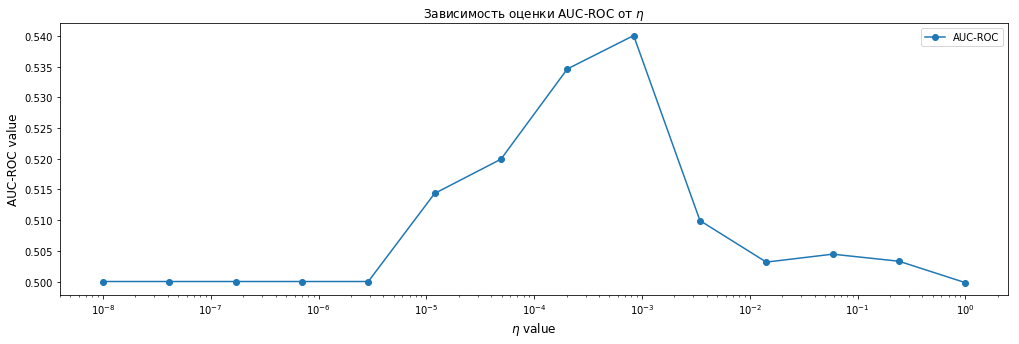

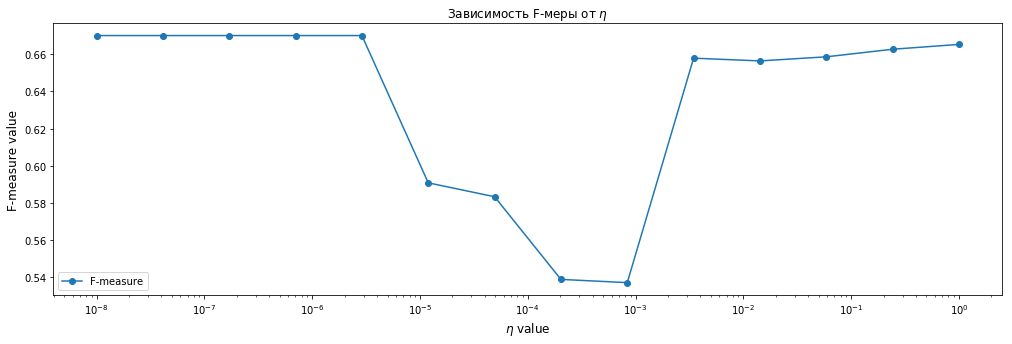

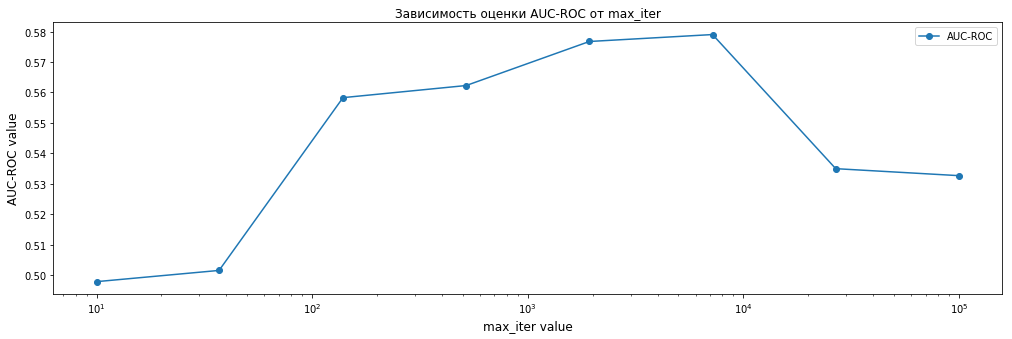

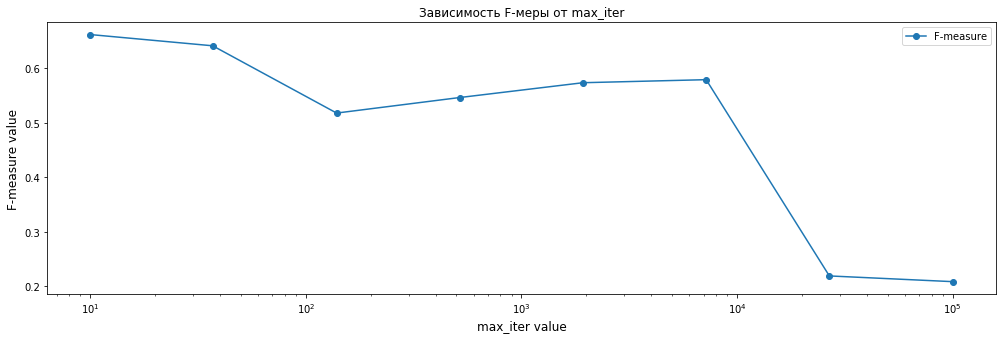

In [103]:
# ---  alpha change --- #
pplot_log(logspace_alpha_full, aucroc_f1_alpha_full.T[0], label_plot='AUC-ROC',
          title='Зависимость оценки AUC-ROC от $\eta$',
          xlabel='$\eta$ value', ylabel='AUC-ROC value')

pplot_log(logspace_alpha_full, aucroc_f1_alpha_full.T[1], label_plot='F-measure',
          title='Зависимость F-меры от $\eta$',
          xlabel='$\eta$ value', ylabel='F-measure value')

# --- max_iter change --- # 
pplot_log(logspace_max_iter_full, aucroc_f1_max_iter_full.T[0], label_plot='AUC-ROC',
          title='Зависимость оценки AUC-ROC от max_iter',
          xlabel='max_iter value', ylabel='AUC-ROC value')

pplot_log(logspace_max_iter_full, aucroc_f1_max_iter_full.T[1], label_plot='F-measure',
          title='Зависимость F-меры от max_iter',
          xlabel='max_iter value', ylabel='F-measure value')


In [125]:
print('## Stochastic gradient method ##')
# --- calculating --- #
logspace_alpha_st = np.logspace(-8, 1, num=14, base=10)
logspace_max_iter_st = np.logspace(1, 6, num=12, base=10).round()

aucroc_f1_alpha_st = np.array(list(map(lambda x: aucroc_f1_calculate_st(x, 10000), logspace_alpha_st)))
print(aucroc_f1_alpha_st, logspace_alpha_st)

aucroc_f1_max_iter_st = np.array(list(map(lambda x: aucroc_f1_calculate_st(5*1e-3, int(x)), logspace_max_iter_st)))
print(aucroc_f1_max_iter_st, logspace_max_iter_st)


## Stochastic gradient method ##


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


[[0.53760513 0.54329931]
 [0.53794093 0.54347826]
 [0.53861252 0.54383652]
 [0.53630595 0.53986107]
 [0.53642329 0.53243697]
 [0.5364184  0.53275109]
 [0.53739312 0.51280253]
 [0.53351358 0.52348536]
 [0.54148334 0.60755149]
 [0.52016886 0.66790525]
 [0.5        0.        ]
 [0.4964187  0.66487936]
 [0.49315519 0.64950128]
 [0.5        0.66991798]] [1.00000000e-08 4.92388263e-08 2.42446202e-07 1.19377664e-06
 5.87801607e-06 2.89426612e-05 1.42510267e-04 7.01703829e-04
 3.45510729e-03 1.70125428e-02 8.37677640e-02 4.12462638e-01
 2.03091762e+00 1.00000000e+01]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log


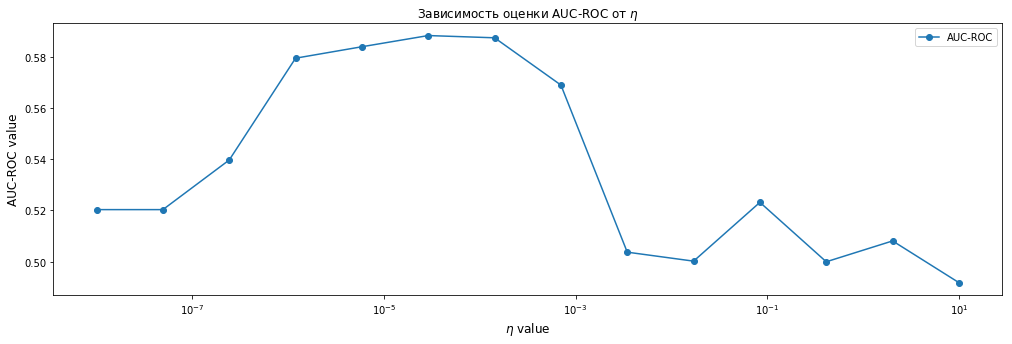

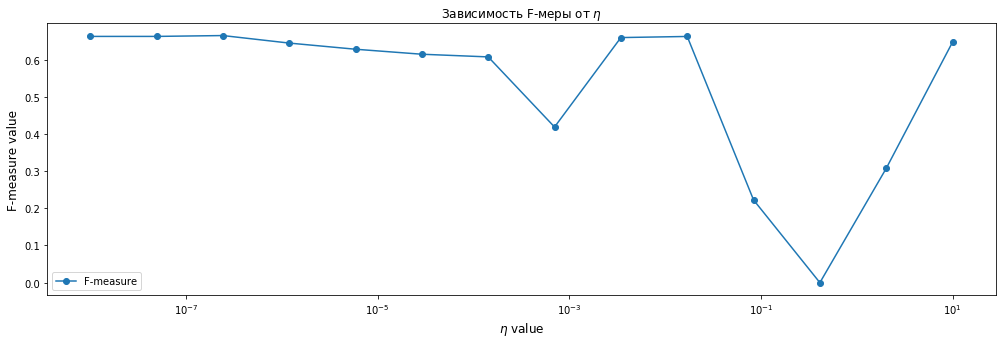

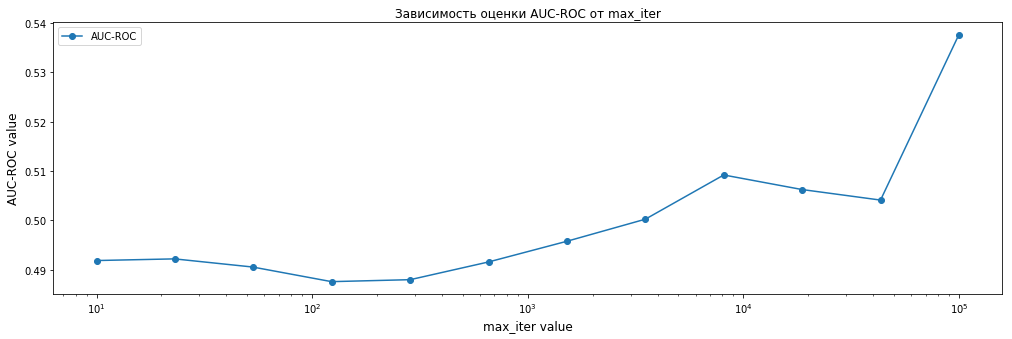

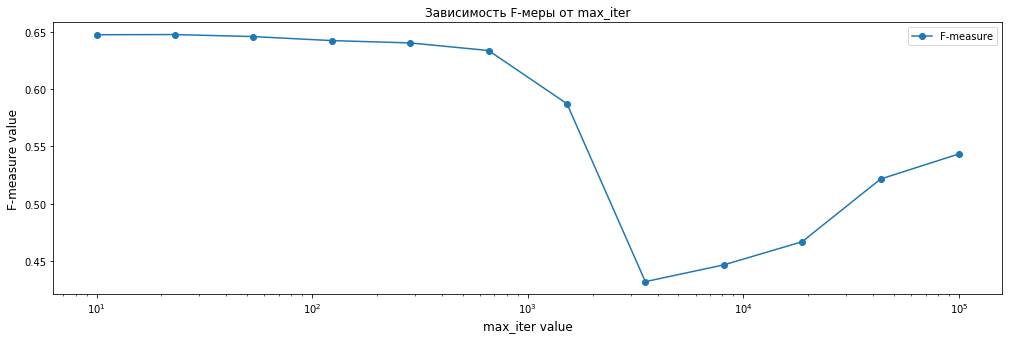

In [124]:
# ---  alpha change --- #
pplot_log(logspace_alpha_st, aucroc_f1_alpha_st.T[0], label_plot='AUC-ROC',
          title='Зависимость оценки AUC-ROC от $\eta$',
          xlabel='$\eta$ value', ylabel='AUC-ROC value')

pplot_log(logspace_alpha_st, aucroc_f1_alpha_st.T[1], label_plot='F-measure',
          title='Зависимость F-меры от $\eta$',
          xlabel='$\eta$ value', ylabel='F-measure value')

# --- max_iter change --- # 
pplot_log(logspace_max_iter_st, aucroc_f1_max_iter_st.T[0], label_plot='AUC-ROC',
          title='Зависимость оценки AUC-ROC от max_iter',
          xlabel='max_iter value', ylabel='AUC-ROC value')

pplot_log(logspace_max_iter_st, aucroc_f1_max_iter_st.T[1], label_plot='F-measure',
          title='Зависимость F-меры от max_iter',
          xlabel='max_iter value', ylabel='F-measure value')


**Задание 6 (1.5 балла)**. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для полного, стохастического градиентного спусков, а также для полного градиентного спуска с методом Momentum. Постройте аналогичные графики для зависимости от времени работы в секундах. Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Назовём график *красивым*, если он соответствует требованиям, предъявленным к графикам в первом дз. В этом задании от вас требуются красивые графики.

### Бонус

Бонусные задачи оцениваются особенно строго. Оценка может быть снижена за плохой код и даже за некрасивые названия переменных. Подсказок не даём.

**Задание 7 (0.5 баллов)**. Правда ли, что лог-лосс является выпуклой функцией относительно $w$? Правда ли, что она является Липшицевой относительно $w$? Почему?

**Задание 8 (3 балла)**. В этом задании на 2 балла засчитывается один из двух пунктов:
 * Реализуйте логистическую регрессию с лог-лоссом, обучаемую с помощью метода [Adam](https://arxiv.org/pdf/1412.6980.pdf)
 * Реализуйте логистическую регрессию с лог-лоссом, обучаемую с помощью [метода Ньютона](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization)

добавьте при необходимости параметры в класс модели, повторите пункты 5 и 6 и сравните результаты.

На 3 балла засчитываются оба пункта со сравнением методов и выводами.

**Задание 9 (0.00 баллов)**.  Вставьте ниже самый смешной или самый грустный график, который получился у вас в этом дз.

## Часть 2: линейная регрессия и feature importance

В этой части мы проанализируем то, как работает линейная регрессия и регуляризация. Тут уже можно пользоваться sklearn'ом.

__Задание 9__ (0 баллов). Загрузите обучающие данные из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/data). Разделите выборку в отношении 7:3. Преобразуйте целевую переменную (trip_duration) как $\widetilde{y} = \log(1 + y)$. Удалите столбец id, а также столбцы, содержащие дату и время. Отнормируйте признаки при помощи MinMaxScaler'a. Как вы думаете, почему такое преобразование имеет смысл?

__Задание 10__ (1 балл). Обучите три вида линейной регрессии на получившихся данных: обычную, Ridge и Lasso. Оцените качество при помощи MSE и $R^2$.

__Задание 11__ (1 балл). Постройте графики зависимости значения метрик из предыдущего задания от значения коэффициента регуляризации для методов Lasso и Ridge. Какие выводы можно сделать?

Хорошие ли получились результаты?

__Задание 12__ (0.5 баллов). При помощи кросс-валидации найдите оптимальные значения коэффициента регуляризации для методов Ridge и Lasso.

__Задание 13__ (0.5 баллов). Постройте bar plot весов признаков для каждой из трёх моделей (на одном рисунке). Какие выводы можно сделать?

Какие фичи оказались наиболее важными? Согласуется ли это с вашими ожиданиями?

__Задание 14__ (2 балла). Добавьте в датасет дополнительные признаки, основываясь на существующих, чтобы получить значение метрики MSE не более 0.4. Что вы для этого сделали?